In [ ]:
import os
# Neural network API
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.optimizers import Adam
from google.colab import files
from PIL import Image

# Random Module
import random

# Data manipulation and linear algebra
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import cv2

from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the path to your daiimagesmages
dataset_path = '/content/drive/MyDrive/dataset/images_processed'  # Update with your actual path

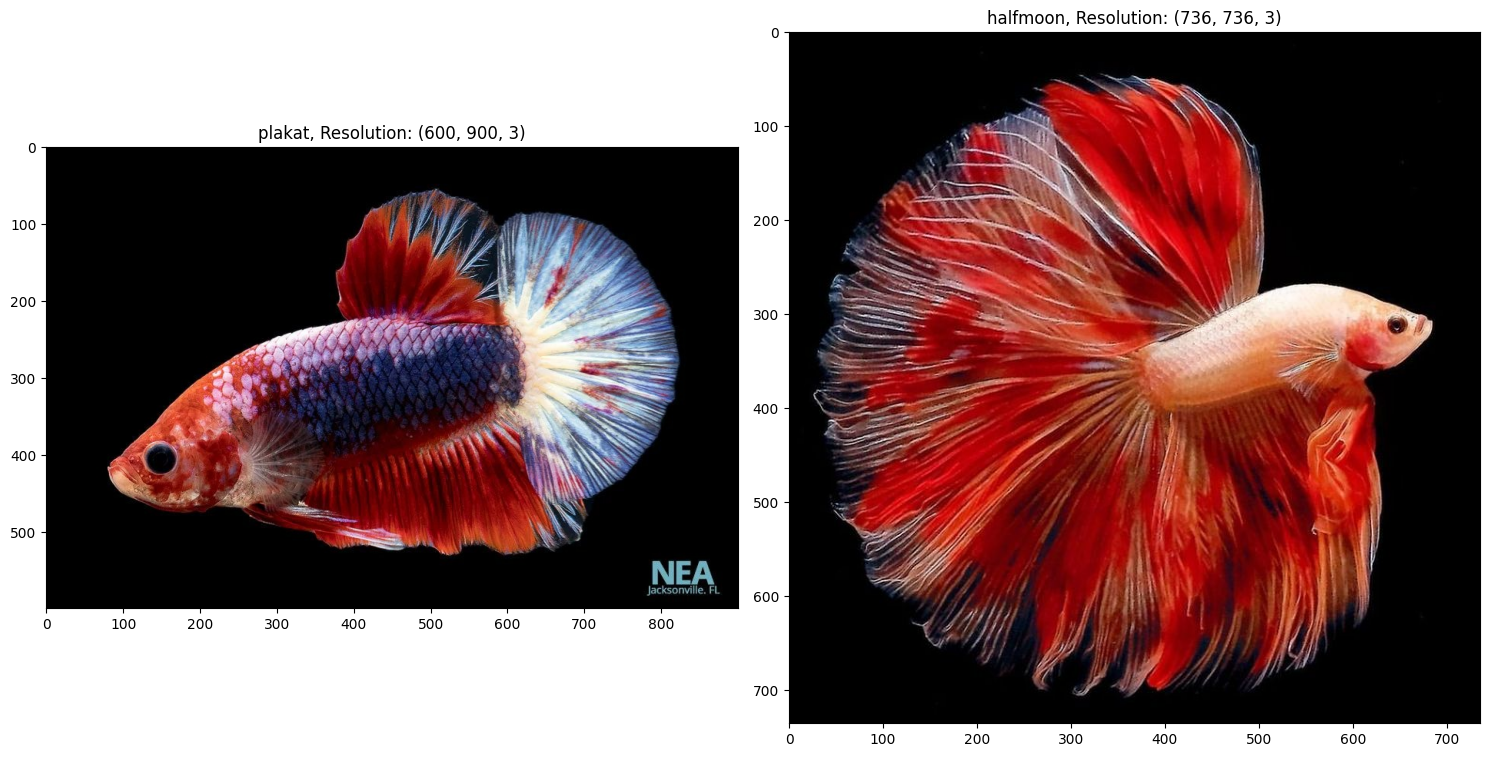

In [ ]:
def load_and_display_images(dataset_path):
    for filename in os.listdir(dataset_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(dataset_path, filename)

            # Load image using Pillow (PIL)
            img = Image.open(file_path)

            # Display image using matplotlib
            plt.imshow(img)
            plt.title(filename)
            plt.show()

fig, ax = plt.subplots(1,2, figsize=(15,8))

# Cataract
plakat_img = mpimage.imread(dataset_path + '/plakat/plakat_21.jpg')
ax[0].imshow(plakat_img)
ax[0].set_title(f'plakat, Resolution: {plakat_img.shape}')

# Normal
halfmoon_img = mpimage.imread(dataset_path +'/halfmoon/halfmoon_31.jpg')
ax[1].imshow(halfmoon_img)
ax[1].set_title(f'halfmoon, Resolution: {halfmoon_img.shape}')

plt.tight_layout()
plt.show()

In [ ]:
train_dir = '/content/drive/MyDrive/dataset/train'
test_dir = '/content/drive/MyDrive/dataset/test'

In [ ]:
# Data augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Match the input shape
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Match the input shape
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb'
)

Found 400 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [ ]:
# Load VGG16 model dengan bobot dari ImageNet, tanpa fully connected layer di akhir
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Membekukan lapisan dari base model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])# 20 kelas untuk 20 jenis ikan cupang

In [ ]:
model.summary()

In [ ]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [ ]:
steps_per_epoch_train = len(train_generator)
steps_per_epoch_test = len(test_generator)

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    validation_data=test_generator,
    validation_steps=steps_per_epoch_test,
    epochs=100,
    callbacks=[model_checkpoint]
)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 2.5719 - accuracy: 0.1400 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 365s 29s/step - loss: 2.5719 - accuracy: 0.1400 - val_loss: 2.0815 - val_accuracy: 0.2500
Epoch 2/100
13/13 [==============================] - 331s 27s/step - loss: 2.4453 - accuracy: 0.1350 - val_loss: 1.9029 - val_accuracy: 0.3300
Epoch 3/100
13/13 [==============================] - 305s 24s/step - loss: 2.0616 - accuracy: 0.2475 - val_loss: 1.6949 - val_accuracy: 0.4100
Epoch 4/100
13/13 [==============================] - 333s 26s/step - loss: 1.8647 - accuracy: 0.3275 - val_loss: 1.5691 - val_accuracy: 0.4600
Epoch 5/100
13/13 [==============================] - 303s 23s/step - loss: 1.7777 - accuracy: 0.3825 - val_loss: 1.5045 - val_accuracy: 0.5100
Epoch 6/100
13/13 [==============================] - 333s 26s/step - loss: 1.7285 - accuracy: 0.4175 - val_loss: 1.3929 - val_accuracy: 0.4500
Epoch 7/100
13/13 [==============================] - 305s 23s/step - loss: 1.5608 - accuracy: 0.4400 - val_loss: 1.3309 - val_accuracy: 0.5100
Epoch 8/100

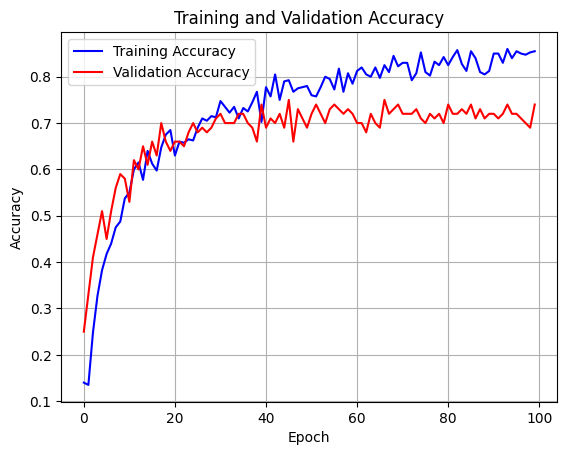

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()

# Extract accuracy data from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Configure the plot
epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


1/1 [==============================] - 1s 653ms/step
Predicted class: halfsun


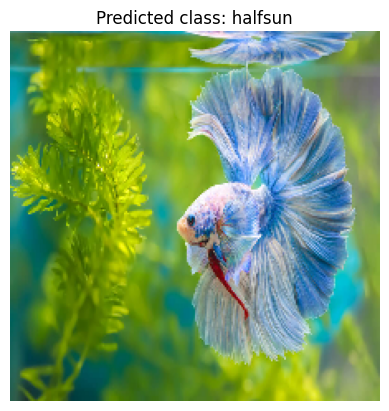

In [ ]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk memuat dan memproses gambar baru
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Muat gambar dan ubah ukurannya
    img_array = image.img_to_array(img)  # Ubah gambar menjadi array
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
    img_array /= 255.0  # Rescale nilai pixel
    return img_array

# Fungsi untuk memprediksi kelas gambar
def predict_image_class(model, img_path, class_indices):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    class_labels = {v: k for k, v in class_indices.items()}  # Membalikkan class_indices
    return class_labels[predicted_class[0]]

# Misalkan Anda memiliki model yang telah dilatih
# class_indices bisa didapat dari train_generator.class_indices
class_indices = train_generator.class_indices

# Path ke gambar baru yang ingin diuji
new_image_path = '/content/drive/MyDrive/rosetail-betta-fish.jpg'

# Prediksi kelas gambar baru
predicted_class = predict_image_class(model, new_image_path, class_indices)
print(f"Predicted class: {predicted_class}")

# Menampilkan gambar baru
img = image.load_img(new_image_path, target_size=(224, 224))
plt.imshow(img)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()
